# SVM

## Preparing Libraries and Dataset

### Import Libraries

In [70]:
####### Import Libraries
import pandas as pd
import re
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Preprocessing dataset

In [71]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [72]:
df = pd.read_csv("/content/learning_outcomes.csv")

df["Learning_Outcome"] = df["Learning_Outcome"].astype(str).apply(clean_text)

X = df["Learning_Outcome"]
y = df["Level"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


### Training

#### Pipeline

In [74]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

#### Param Tuning

In [75]:
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],
    "svm__C": [0.1, 1.0, 10.0]
}

#### Training

In [76]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1.0, 10.0], 'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

#### Eval F-1 Score & Accuracy

In [77]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Params: {'svm__C': 10.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8033635187580854
              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         1
          A3       0.00      0.00      0.00         2
          A4       0.68      0.65      0.67        23
          A5       0.67      0.78      0.72        23
          C1       0.86      0.96      0.91        26
          C2       0.89      0.90      0.89       147
          C3       0.78      0.65      0.71        88
          C4       0.86      0.83      0.84       146
          C5       0.72      0.79      0.76        63
          C6       0.87      0.91      0.89       140
          P2       0.62      0.56      0.59         9
          P3       0.68      0.72      0.70        67
          P4       0.58      0.61      0.59        31
          P5       0.75      0.43      0.55         7

    accuracy                           0.80       773
   macro avg       0.64  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


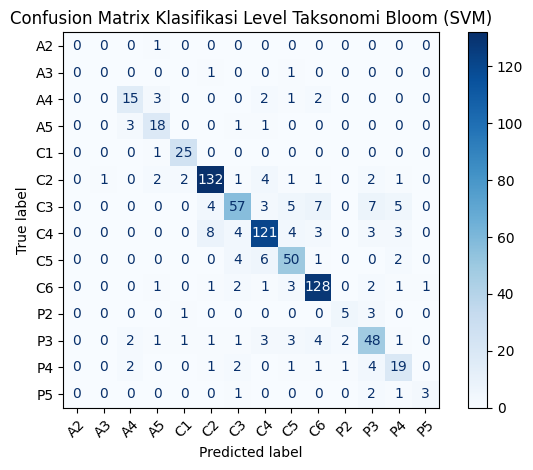

In [78]:
labels = sorted(y_test.unique(), key=lambda x: (x[0], int(x[1:])))
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    cmap="Blues",
    values_format="d",
    xticks_rotation=45
)

plt.title("Confusion Matrix Klasifikasi Level Taksonomi Bloom (SVM)")
plt.tight_layout()
plt.show()

#### Save Model

In [35]:
joblib.dump(best_model, "svm_bloom_level_tuned.pkl")
print("Model saved: svm_bloom_level_tuned.pkl")

Model saved: svm_bloom_level_tuned.pkl


#### Alignment Eval

In [37]:
model = joblib.load("svm_bloom_level_tuned.pkl")
df = pd.read_csv("cpmk_subcpmk_pairs.csv")

In [38]:
df["pred_level_cpmk"] = model.predict(df["cpmk"].astype(str))
df["pred_level_subcpmk"] = model.predict(df["subcpmk"].astype(str))


In [39]:
def parse_level(label):
    if not isinstance(label, str) or len(label) < 2:
        return None, None
    return label[0], int(label[1:])

In [40]:
def check_alignment(row):
    dom_c, lvl_c = parse_level(row["pred_level_cpmk"])
    dom_s, lvl_s = parse_level(row["pred_level_subcpmk"])

    if dom_c is None or dom_s is None:
        return "Tidak Selaras"

    if dom_c != dom_s:
        return "Tidak Selaras"

    if lvl_s <= lvl_c:
        return "Selaras"

    return "Tidak Selaras"


df["pred_keselarasan"] = df.apply(check_alignment, axis=1)

In [67]:
print("\n=== Alignment Evaluation ===")
print(pd.crosstab(
    df["keselarasan"],
    df["pred_keselarasan"],
    rownames=["Actual"],
    colnames=["Predicted"]
))

df["keselarasan_str"] = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

# Prediction already string
df["pred_keselarasan_str"] = df["pred_keselarasan"]


y_true = df["keselarasan_str"]
y_pred = df["pred_keselarasan_str"]

acc = accuracy_score(y_true, y_pred)
acc

print(f"\nAccuracy Score:  {acc:.2%}%")


=== Alignment Evaluation ===
Predicted  Selaras  Tidak Selaras
Actual                           
False           44            366
True           827             51

Accuracy Score:  92.62%%


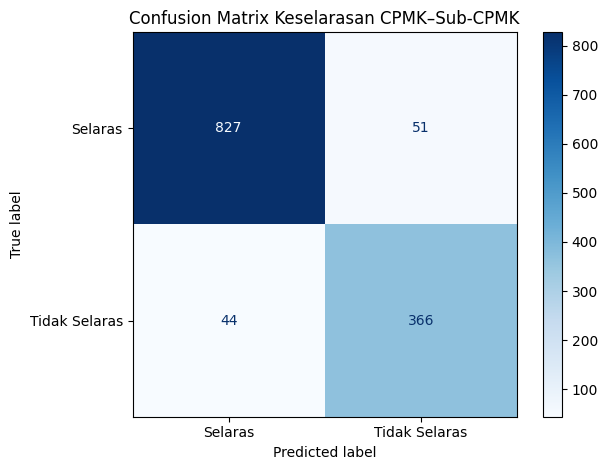

In [50]:
y_true = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

y_pred = df["pred_keselarasan"]



labels = ["Selaras", "Tidak Selaras"]

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix Keselarasan CPMK–Sub-CPMK")
plt.tight_layout()
plt.show()